In [1]:
# ライブラリをインポート
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
from datetime import datetime, timedelta

import yfinance as yf
import mplfinance as mpf  # ローソク足グラフの作成ライブラリ

# 他の株価取得ライブラリ
# import pandas_datareader as pdr
# import yahooquery as yq

C:\Users\msg22\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## ◆ ティッカーシンボル
#### 指数　[日経平均株価：^N225], [ダウ平均株価：^DJI], [ナスダック総合指数：^IXIC], [S&P500指数：^GSPC], [VIX指数：^VIX]
#### 為替　[米ドル/日本円：USDJPY=X], [ユーロ/日本円：EURJPY=X]
#### ETF　[インド：EPI], [ベトナム：VNM], [トルコ：TUR], [メキシコ：EWW]
#### 暗号資産　[ビットコイン：BTC-USD], [イーサリアム：ETH-USD]

In [2]:
# 株価を取得する関数
def get_stock_price(ticker, period, interval):
    data = yf.download(ticker, period = period, interval = interval)
    return data

def get_stock_price(ticker, period, interval, ma_periods=[50, 75], bb_period=20, bb_std=2):
    # 株価データの取得
    data = yf.download(ticker, period=period, interval=interval)
    
    # 移動平均線の計算
    for ma_period in ma_periods:
        data[f'MA_{ma_period}'] = data['Close'].rolling(window=ma_period).mean()
    
    # ボリンジャーバンドの計算
    data['BB_Middle'] = data['Close'].rolling(window=bb_period).mean()
    data['BB_StdDev'] = data['Close'].rolling(window=bb_period).std()
    data['BB_Upper'] = data['BB_Middle'] + (data['BB_StdDev'] * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (data['BB_StdDev'] * bb_std)
    
    return data

In [3]:
# 株価を取得したい銘柄を指定
################
ticker = '7012.T'
period = '2y'
interval = '1d'
################

# 株価を取得
data = get_stock_price(ticker, period, interval)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_75,BB_Middle,BB_StdDev,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2022-12-30,3100.0,3130.0,3075.0,3090.0,2954.122559,1080400,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,3040.0,3060.0,2976.0,2976.0,2845.135254,2084700,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,2989.0,3020.0,2907.0,2927.0,2798.290283,2125500,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-06,2947.0,2963.0,2908.0,2937.0,2807.850098,1764800,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-10,2942.0,2985.0,2911.0,2932.0,2803.070312,2217700,NaN,NaN,NaN,NaN,NaN,NaN


## 売買タイミングをプロットさせる

In [112]:
# ディレクトリを指定
input_data = 'data/'

# データの読み込み
rakuten = pd.read_excel(input_data + '02_運用_rakuten.xlsx', sheet_name = '国内株式_特定')
rakuten['銘柄コード'] = rakuten['銘柄コード'].astype(str)  # 銘柄コード列を文字列に変換
rakuten.head()

,約定日,受渡日,銘柄コード,銘柄名,口座区分,取引区分,売買区分,数量［株］,単価［円］,手数料［円］,税金等［円］,税区分,受渡金額［円］,実現損益[円]
0,2021-01-20 00:00:00,2021-01-22,2503,キリンＨＤ,特定,現物,買付,100,2265.9,0,0,-,226590.0,0.0
1,2021-01-21 00:00:00,2021-01-25,2503,キリンＨＤ,特定,現物,売付,100,2306.4,0,0,源徴あり,230640.0,4050.0
2,2021-01-21 00:00:00,2021-01-25,3395,サンマルクホールディングス,特定,現物,買付,100,1490.0,0,0,-,149000.0,0.0
3,2021-01-25 00:00:00,2021-01-27,4188,三菱ケミカルＨＬＤＧＳ,特定,現物,買付,100,745.3,0,0,-,74530.0,0.0
4,2021-01-25 00:00:00,2021-01-27,7616,コロワイド,特定,現物,買付,100,1817.0,0,0,-,181700.0,0.0


In [120]:
# 売買したことのある銘柄の名前を取得しリスト化
list_from_column = rakuten['銘柄名'].unique().tolist()
list_from_column

['キリンＨＤ',
 'サンマルクホールディングス',
 '三菱ケミカルＨＬＤＧＳ',
 'コロワイド',
 'シャープ',
 'キヤノン',
 'クラレ',
 'ＥＮＥＯＳホールディングス',
 '日本たばこ産業',
 '良品計画',
 'リコー',
 '森永製菓',
 'トリドールホールディングス',
 '日揮ホールディングス',
 '東京電力ホールディングス',
 'コクヨ',
 '日鉄物産',
 '住友化学',
 'ぴあ',
 'サントリー食品インター',
 '三菱重工業',
 '三菱地所',
 '堺化学',
 '京浜急行',
 '電源開発',
 'ライオン',
 '川崎重工業',
 'ロート製薬',
 'ＡＮＡホールディングス',
 'ワコールホールディングス',
 '商船三井',
 '川崎汽船',
 '乾汽船',
 '日本郵船',
 'ヤマハ',
 '塩野義製薬',
 'ソフトバンクグループ',
 '明治ホールディングス',
 '東日本旅客鉄道',
 '京セラ',
 'ＫＤＤＩ',
 '花王',
 'ＩＨＩ',
 '三菱商事',
 'エフピコ',
 '東京海上ＨＤ',
 'ブリヂストン',
 'アルコニックス',
 'オリンパス',
 '東宝',
 '任天堂',
 '日本製鉄',
 'アステラス製薬',
 '日本曹達',
 'ジャックス',
 '長谷川香料',
 'フェローテックHD',
 '出光興産',
 'ニチアス',
 '信越化学',
 'イオン',
 'TOTO',
 '三井物産',
 '双日',
 '住友林業',
 'ファナック',
 '中外製薬',
 '味の素',
 '伊藤忠',
 '電通グループ',
 'オリエンタルランド',
 'アサヒグループHD',
 '積水ハウス',
 'エーザイ',
 'ニッタ',
 'コスモエネルギーＨＬＤＧＳ',
 'ADEKA',
 '三井化学',
 '長瀬産業',
 '三井住友フィナンシャルG',
 '日本航空',
 'タカラトミー',
 'ジーエルサイエンス',
 'アルトナー',
 'ソシオネクスト',
 'アイティメディア',
 '東京エレクトロンデバイス',
 'アドバンテスト',
 'トヨタ自動車',
 'ＳＣＲＥＥＮホールディングス',
 'ディー・エヌ・エー',
 'さくらインターネット',


In [132]:
# 特定の銘柄コードの約定日と売買区分を取得する関数を定義
def get_transaction_details(df, stock_code):
    filtered_df = df[df['銘柄コード'] == stock_code]
    transaction = filtered_df[['銘柄コード','銘柄名','約定日', '売買区分']]
    return transaction

# 売買の日付をリストで取得
def get_trade_date_list(df, buy_or_sell):
    trade_date = df[df['売買区分'] == buy_or_sell]
    trade_date_list = list(trade_date['約定日'])
    return trade_date_list

# 銘柄リストから銘柄コードを取得
stock_name = list_from_column[30]
stock_code, = rakuten.loc[rakuten['銘柄名'] == stock_name, '銘柄コード'].unique()
print(stock_code)

# お試しコード
target_data = get_transaction_details(rakuten, stock_code)
buy = get_trade_date_list(target_data, '買付')
sell = get_trade_date_list(target_data, '売付')

9104


<function matplotlib.pyplot.show(*args, **kw)>

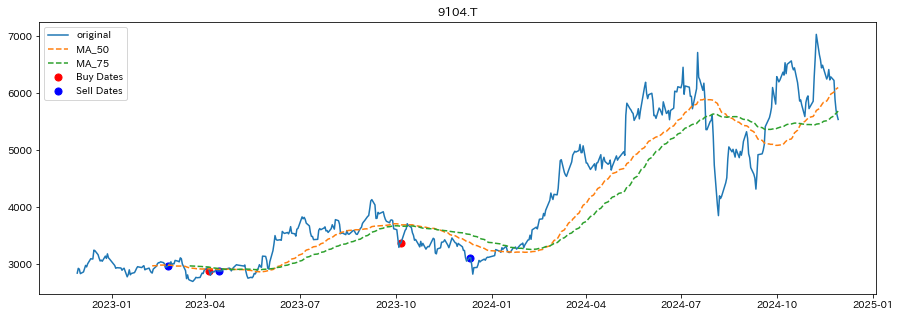

In [137]:
# 取得したチャートデータの可視化
ticker = stock_code + '.T'

plt.figure(figsize=(15,5))
plt.plot(data['Close'], label='original')
plt.plot(data['MA_50'], label='MA_50', linestyle='--')
plt.plot(data['MA_75'], label='MA_75', linestyle='--')

# 買付日リストの点を赤色で追加
buy_data = data[data.index.isin(buy)]
plt.scatter(buy_data.index, buy_data['Close'], color='red', label='Buy Dates', marker='o', s=50)

# 売付日リストの点を青色で追加
sell_data = data[data.index.isin(sell)]
plt.scatter(sell_data.index, sell_data['Close'], color='blue', label='Sell Dates', marker='o', s=50)

plt.title(ticker)
# plt.xlabel()
# plt.ylabel()
plt.legend()
plt.grid(False)
plt.show

In [ ]:
# ローソク足グラフで株価を可視化
# mpf.plot(data, type = 'candle', mav=(50, 200), volume=True, figratio = (15, 5), style='yahoo')

In [ ]:
# 選択可能なstyleを表示
# mpf.available_styles()

# 株価に関連する情報の取得

In [5]:
# 株価に関連する情報の取得
ticker = '2501.T'

stock_data = yf.Ticker(ticker)
stock_data.info

{'address1': '20-1, Ebisu 4-chome',
 'address2': 'Shibuya-ku',
 'city': 'Tokyo',
 'zip': '150-8522',
 'country': 'Japan',
 'phone': '81 3 6859 2304',
 'fax': '81 3 5423 2061',
 'website': 'https://www.sapporoholdings.jp',
 'industry': 'Beverages - Brewers',
 'industryKey': 'beverages-brewers',
 'industryDisp': 'Beverages - Brewers',
 'sector': 'Consumer Defensive',
 'sectorKey': 'consumer-defensive',
 'sectorDisp': 'Consumer Defensive',
 'longBusinessSummary': 'Sapporo Holdings Limited engages in alcoholic beverages, foods and soft drinks, restaurants, and real estate businesses in Japan and internationally. The company operates through Alcoholic Beverages, Food & Soft Drinks, and Real Estate segments. It manufactures and sells beer, wine, other alcoholic beverages, and other food products. In addition, the company operates restaurants and factories; and offers soft drinks, soups, and soybeans ice creams, and chilled products, as well as provides consigned freight forwarding, cargo han

In [6]:
stock_data.actions  # アクション（配当、分割）を表示
stock_data.dividends  # 配当のみ表示
stock_data.splits  # 分割のみ表示

#stock_data.capital_gains  # ?

Date
2016-06-28 00:00:00+09:00    0.2
Name: Stock Splits, dtype: float64

In [7]:
# 損益計算書の取得
stock_data.income_stmt  # 年単位
stock_data.quarterly_income_stmt  # 4ヶ月単位

,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,0.0,NaN
Tax Rate For Calcs,0.237554,0.232,0.232,0.31664,0.232,NaN
Normalized EBITDA,16946000000.0,4330000000.0,9880000000.0,17841000000.0,6474000000.0,NaN
Net Income From Continuing Operation Net Minority Interest,8058000000.0,-1977000000.0,5666000000.0,8162000000.0,-1508000000.0,NaN
Reconciled Depreciation,5496000000.0,5218000000.0,5597000000.0,5147000000.0,5142000000.0,NaN
Reconciled Cost Of Revenue,90847000000.0,81193000000.0,98981000000.0,94639000000.0,89371000000.0,NaN
EBITDA,16946000000.0,4330000000.0,9880000000.0,17841000000.0,6474000000.0,NaN
EBIT,11450000000.0,-888000000.0,4283000000.0,12694000000.0,1332000000.0,NaN
Net Interest Income,976000000.0,414000000.0,1278000000.0,-460000000.0,-10000000.0,NaN
Interest Expense,884000000.0,619000000.0,739000000.0,753000000.0,847000000.0,NaN


In [8]:
# バランスシートの取得
stock_data.balance_sheet  # 年単位
stock_data.quarterly_balance_sheet   # 4ヶ月単位

,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31
Treasury Shares Number,871464.0,895935.0,895451.0,769108.0,768492.0,NaN
Ordinary Shares Number,77922834.0,77898363.0,77898847.0,78025190.0,78025806.0,NaN
Share Issued,78794298.0,78794298.0,78794298.0,78794298.0,78794298.0,NaN
Net Debt,208562000000.0,218522000000.0,205398000000.0,210718000000.0,215629000000.0,NaN
Total Debt,253904000000.0,258594000000.0,245624000000.0,252106000000.0,256802000000.0,NaN
...,...,...,...,...,...,...
Accounts Receivable,88312000000.0,77478000000.0,98023000000.0,90957000000.0,82631000000.0,NaN
Gross Accounts Receivable,88312000000.0,77478000000.0,98023000000.0,90957000000.0,82631000000.0,NaN
Cash Cash Equivalents And Short Term Investments,25053000000.0,21739000000.0,21597000000.0,22874000000.0,21016000000.0,NaN
Other Short Term Investments,4888000000.0,4559000000.0,4393000000.0,4289000000.0,3630000000.0,NaN


In [20]:
# キャッシュフローの取得
stock_data.cashflow  # 年単位
stock_data.quarterly_cashflow  # 4半期単位

,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Free Cash Flow,1812000000.0,-4171000000.0,941000000.0,8517000000.0,6787000000.0,NaN,NaN
Repurchase Of Capital Stock,NaN,-3000000.0,NaN,NaN,NaN,-1000000.0,NaN
Repayment Of Debt,-1000000.0,-4501000000.0,-2000000.0,-26502000000.0,-5019000000.0,NaN,NaN
Issuance Of Debt,2000000.0,69000000.0,12000000000.0,0.0,23000000000.0,NaN,NaN
Capital Expenditure,-7581000000.0,-5829000000.0,-6332000000.0,-5088000000.0,-4282000000.0,NaN,NaN
End Cash Position,20165000000.0,17180000000.0,17204000000.0,18585000000.0,17386000000.0,NaN,NaN
Other Cash Adjustment Outside Changein Cash,115000000.0,-114000000.0,NaN,NaN,NaN,NaN,NaN
Beginning Cash Position,17180000000.0,17204000000.0,18585000000.0,17386000000.0,14109000000.0,NaN,NaN
Effect Of Exchange Rate Changes,1798000000.0,724000000.0,-241000000.0,-1849000000.0,670000000.0,NaN,NaN
Changes In Cash,1072000000.0,-634000000.0,-1141000000.0,3049000000.0,2607000000.0,NaN,NaN


In [25]:
# # 株主情報の取得
# stock_data.major_holders  # 大株主
# stock_data.institutional_holders
# stock_data.mutualfund_holders
# stock_data.insider_transactions
# stock_data.insider_purchases
# stock_data.insider_roster_holders

YFDataException: Failed to parse holders json data.

In [9]:
# 証券会社評価の取得
stock_data.recommendations
#stock_data.recommendations_summary
#stock_data.upgrades_downgrades

,period,strongBuy,buy,hold,sell,strongSell
0,0m,0,0,1,2,0
1,-1m,0,0,2,2,0


In [10]:
# EPSの取得
stock_data.earnings_dates

KeyError: 'Earnings Date'

In [11]:
# ニュース情報の取得
stock_data.news

[{'uuid': 'df8ee90e-e8b3-31d0-a25c-cad820495b90',
  'title': 'CrowdStrike Holdings, Inc. (CRWD): KeyBanc Reaffirms $395 Target Amid Strong Q3 Growth and AI-Driven Cybersecurity Leadership',
  'publisher': 'Insider Monkey',
  'link': 'https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-keybanc-120035078.html',
  'providerPublishTime': 1733054435,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/eSXzRwwyPBRoXDSfsjazwA--~B/aD04MTY7dz0xNDU2O2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/insidermonkey.com/f19224defcc7729b058ac2b2e8bb6d1b',
     'width': 1456,
     'height': 816,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/.P9gjIM5syrYJZPdz.IrNA--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/insidermonkey.com/f19224defcc7729b058ac2b2e8bb6d1b',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['CRWD']},
 {'uuid': '2c995b6d-a319-36ae-90e

In [12]:
import os
import pandas_datareader.data as web

f = web.DataReader('ticker=RGDPUS', 'econdb')
f.head()

KeyError: 'results'

# Plotlyで描画

In [43]:
# ライブラリをインポート
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ta
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# 描画をブラウザで表示（ノートブック上ではなぜか表示されない）
import plotly.io as pio
pio.renderers.default = "browser"

In [1]:
# 株価データを描画する関数
def plot_stock_price(ticker, period, interval):
    data = yf.download(ticker, period = period, interval = interval)
    # プロットの区切りを設定
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.03, row_heights=[0.5, 0.25, 0.25])

    # 1段目の株価の主データを描画
    fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='original'), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'].rolling(window=50).mean(), name='MA50', line=dict(color='lightblue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'].rolling(window=75).mean(), name='MA75', line=dict(color='lightsalmon')), row=1, col=1)

    # ボリンジャーバンドも描画
    indicator_bb = BollingerBands(close=data["Close"], window=20, window_dev=2)
    fig.add_trace(go.Scatter(x=data.index, y=indicator_bb.bollinger_hband(), name='Upper BB', line=dict(color='palevioletred', dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=indicator_bb.bollinger_lband(), name='Lower BB', line=dict(color='palevioletred', dash='dash')), row=1, col=1)

    # 2段目にRSIを描画
    rsi = RSIIndicator(data['Close']).rsi()
    fig.add_trace(go.Scatter(x=data.index, y=rsi, name='RSI', line=dict(color='rosybrown')), row=2, col=1)

    # 3段目に取引量を描画
    fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume', marker=dict(color='sandybrown')), row=3, col=1)

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()




In [71]:
# 取得した株価データを描画

# プロットの区切りを設定
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.03, row_heights=[0.5, 0.25, 0.25])

# 1段目の株価の主データを描画
fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='original'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Close'].rolling(window=50).mean(), name='MA50', line=dict(color='lightblue')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Close'].rolling(window=75).mean(), name='MA75', line=dict(color='lightsalmon')), row=1, col=1)

# ボリンジャーバンドも描画
indicator_bb = BollingerBands(close=data["Close"], window=20, window_dev=2)
fig.add_trace(go.Scatter(x=data.index, y=indicator_bb.bollinger_hband(), name='Upper BB', line=dict(color='palevioletred', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=indicator_bb.bollinger_lband(), name='Lower BB', line=dict(color='palevioletred', dash='dash')), row=1, col=1)

# 2段目にRSIを描画
rsi = RSIIndicator(data['Close']).rsi()
fig.add_trace(go.Scatter(x=data.index, y=rsi, name='RSI', line=dict(color='rosybrown')), row=2, col=1)

# 3段目に取引量を描画
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume', marker=dict(color='sandybrown')), row=3, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [79]:
# 追加のテクニカル指標を描画

# プロットの区切りを設定
fig2 = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.03, row_heights=[0.25, 0.25, 0.25])

# 1段目に株価のパーセント変化を描画
data['Percent_Change'] = data['Close'].pct_change() * 100
fig2.add_trace(go.Scatter(x=data.index, y=data['Percent_Change'], mode='lines', name='Percent_Change'), row=1, col=1)

# 2段目にMACDチャートを描画
macd = ta.trend.MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Histogram'] = macd.macd_diff()
fig2.add_trace(go.Scatter(x=data.index, y=data['MACD'], name='MACD'), row=2, col=1)
fig2.add_trace(go.Scatter(x=data.index, y=data['MACD_Signal'], name='MACD Signal'), row=2, col=1)

fig2.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD_Histogram',
                     marker=dict(color=(data['MACD_Histogram'] >= 0).astype('int'),
                                 colorscale=[[0, 'lightpink'], [1, 'lightgreen']])), row=3, col=1)

#fig2.update_layout(title='Daily Percent Change')fig.show()
fig2.show()

In [ ]:
# 色の選択肢
aliceblue, antiquewhite, aqua, aquamarine, azure,
beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue,
chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan,
darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange,
darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey,
darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick,
floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green,
greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen,
lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey,
lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey,
lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine,
mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen,
mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy,
oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise,
palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown,
royalblue, rebeccapurple, saddlebrown, salmon,
sandybrown, seagreen, seashell, sienna, silver,
skyblue, slateblue, slategray, slategrey, snow,
springgreen, steelblue, tan, teal, thistle, tomato,
turquoise, violet, wheat, white, whitesmoke,
yellow, yellowgreen

In [73]:
import pandas as pd
import yfinance as yf
import plotly.express as px

# データの取得
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
start_date = '2020-01-01'
end_date = '2023-06-16'  # 現在の日付に近い日付を使用

# yfinance を使用してデータをダウンロード
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# 相関行列の計算
correlation_matrix = data.corr()

# ヒートマップの作成
fig = px.imshow(correlation_matrix, 
                text_auto=True, 
                aspect="auto",
                color_continuous_scale='RdBu_r',  # 赤青のカラースケール
                title="株価の相関行列")

# x軸とy軸のラベルを設定
fig.update_xaxes(title="Stocks")
fig.update_yaxes(title="Stocks")

# レイアウトの調整
fig.update_layout(
    width=700,  # 幅を設定
    height=600,  # 高さを設定
)

# グラフの表示
fig.show()

[*********************100%%**********************]  4 of 4 completed
